In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sys
import os
import cv2
warnings.filterwarnings("ignore")
# sys.path.append("../") # local root
PROJECT_PATH = '/content/drive/MyDrive/likelion/smartphone_defect_segmentation'
sys.path.append(PROJECT_PATH)

from tqdm import tqdm
from src.segtool.config import DataConfig, TrainConfig
from src.segtool.data import (
    make_loaders,
    DefectSegDataset,
    DatasetPaths,
    default_paths,
    find_mask
)
from src.segtool.model import UNet
from src.segtool.models_factory import build_model
from src.segtool.losses import BCEDiceLoss, DiceLoss
from src.segtool.engine import (
    train_one_epoch,
    validate,
    EpochResult,
    _defect_only_metrics
)
from src.segtool.metrics import compute_metrics, reduce_mean, Metrics
from src.segtool.utils import *

In [ ]:
set_seed(42)
device = get_device()
print(device)

cuda


In [ ]:
!nvidia-smi

Thu Jan  8 11:02:30 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Colab root
# dataset_root = "/content/drive/MyDrive/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"

# Local root
dataset_root = "/Users/mungughyeon/Library/CloudStorage/GoogleDrive-moonstalker9010@gmail.com/내 드라이브/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"
records = []
image_class = ["stain", "scratch", "oil", "good"]

for class_name in image_class:
    class_path = os.path.join(dataset_root, class_name)

    if not os.path.isdir(class_path):
        continue

    for file in tqdm(os.listdir(class_path)):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(class_path, file)

            img = cv2.imread(img_path)
            if img is None:
                continue

            h, w, c = img.shape

            # 클래스별로 마스크 찾기
            mask_path = None
            mask_name = file.replace('.jpg', '.png')

            if class_name == "stain":
                potential_mask = os.path.join(dataset_root, "ground_truth_1", mask_name)
                if os.path.exists(potential_mask):
                    mask_path = potential_mask
            elif class_name == "scratch":
                potential_mask = os.path.join(dataset_root, "ground_truth_1", mask_name)
                if os.path.exists(potential_mask):
                    mask_path = potential_mask
            elif class_name == "oil":
                potential_mask = os.path.join(dataset_root, "ground_truth_2", mask_name)
                if os.path.exists(potential_mask):
                    mask_path = potential_mask

            records.append({
                "class": class_name,
                "file_name": file,
                "image_path": img_path,
                "mask_path": mask_path,
                "height": h,
                "width": w,
                "channels": c,
            })

# 증강 데이터 수집
aug_path = os.path.join(dataset_root, "aug")
if os.path.isdir(aug_path):
    for file in tqdm(os.listdir(aug_path)):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(aug_path, file)

            img = cv2.imread(img_path)
            if img is None:
                continue

            h, w, c = img.shape

            # 파일명에서 클래스 추출: aug_oil_Oil_0001.jpg -> oil
            class_name = file.split("_")[1]

            # 증강 마스크 찾기
            mask_path = None
            mask_name = file.replace('.jpg', '.png')
            potential_mask = os.path.join(dataset_root, "aug_mask", mask_name)
            if os.path.exists(potential_mask):
                mask_path = potential_mask

            records.append({
                "class": class_name,
                "file_name": file,
                "image_path": img_path,
                "mask_path": mask_path,
                "height": h,
                "width": w,
                "channels": c,
            })

df = pd.DataFrame(records)
df

""


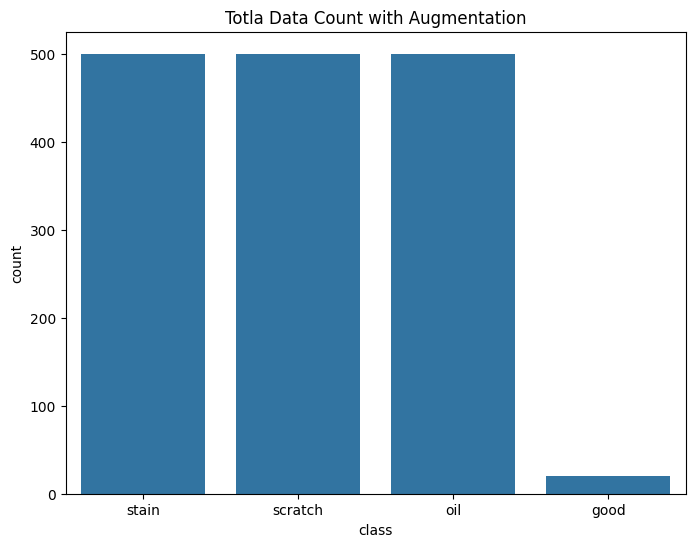

,class,count
0,stain,500
1,scratch,500
2,oil,500
3,good,20


In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='class')
plt.title("Totla Data Count with Augmentation")
plt.show()

df['class'].value_counts().reset_index()

### Augmentation 300

- Class 별 Aug 100장씩 (good 클래스는 제외)
- 총 300장 증강

In [ ]:
# Colab root
dataset_root = "/content/drive/MyDrive/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"
# Local root
# dataset_root = "/Users/mungughyeon/Library/CloudStorage/GoogleDrive-moonstalker9010@gmail.com/내 드라이브/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"

base_path = Path(dataset_root)
train_loader, val_loader, test_loader = make_loaders(
    base_path=base_path,
    img_size_hw=(288, 512),  # (height, width)
    train_ratio=0.7,
    test_ratio=0.15,
    seed=42,
    batch_size=16,
    num_workers=4
)

print(f"Train: {len(train_loader.dataset)}")
print(f"Val: {len(val_loader.dataset)}")
print(f"Test: {len(test_loader.dataset)}")

Train: 1154
Val: 183
Test: 183


In [ ]:
unet = UNet(
    in_channels=3,
    num_classes=1,
    base_channels=64,
    # dropout=0.1
).to(device)

total_params = sum(p.numel() for p in unet.parameters())
trainable_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 31,031,745
Trainable parameters: 31,031,745


In [ ]:
print(f"Num workers: {train_loader.num_workers}")

In [ ]:
# optimizer
optimizer = torch.optim.Adam(
    unet.parameters(),
    lr=1e-3,
    weight_decay=0.0
)

# loss function
criterion = BCEDiceLoss(bce_weight=0.5)  # BCE와 Dice Loss 조합

print(f"Device: {device}")
print(f"Model: {unet.__class__.__name__}")
print(f"Loss function: {criterion.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Num workers: {train_loader.num_workers}")
# print(f"Dropout: {getattr(unet.dropout, 'p', 0.0)}")

Device: cuda
Model: UNet
Loss function: BCEDiceLoss
Optimizer: Adam
Batch size: 16
Learning rate: 0.001
Num workers: 4


In [9]:
import wandb

epochs = 100
best_val_dice = -1.0
threshold = 0.5
early_stopping_patience = 15
no_improve_count = 0

# wandb
wandb_config = {
    "model": unet.__class__.__name__,
    "epochs": epochs,
    "threshold": threshold,
    "batch_size": train_loader.batch_size,
    "learning_rate": optimizer.param_groups[0]['lr'],
    "weight_decay": optimizer.param_groups[0]['weight_decay'],
    "loss": criterion.__class__.__name__,
    "optimizer": optimizer.__class__.__name__,
    "early_stopping_patience": early_stopping_patience,
    "device": str(device),
}

# wandb init
wandb.init(
    project="mobile-phone-defect",
    name=f"{unet.__class__.__name__}_data-300",
    config=wandb_config
)

train_losses = []
val_losses = []
train_dices = []
val_dices = []
val_defect_dices = []

print(f"Starting Training for {epochs} epochs (Early stopping: {early_stopping_patience})")
print("=" * 60)

# loop
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    # Training
    train_result = train_one_epoch(
        model=unet,
        loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # Validation
    val_result = validate(
        model=unet,
        loader=val_loader,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # 기록 저장
    train_losses.append(train_result.loss)
    val_losses.append(val_result.loss)
    train_dices.append(train_result.metrics_all.dice)
    val_dices.append(val_result.metrics_all.dice)
    val_defect_dices.append(val_result.metrics_defect_only.dice)

    # wandb 로깅
    wandb.log({
        "epoch": epoch,
        "train/loss": train_result.loss,
        "train/dice_all": train_result.metrics_all.dice,
        "train/iou_all": train_result.metrics_all.iou,
        "val/loss": val_result.loss,
        "val/dice_all": val_result.metrics_all.dice,
        "val/iou_all": val_result.metrics_all.iou,
        "val/dice_defect": val_result.metrics_defect_only.dice,
        "val/iou_defect": val_result.metrics_defect_only.iou,
        "val/precision_defect": val_result.metrics_defect_only.precision,
        "val/recall_defect": val_result.metrics_defect_only.recall,
    })

    # result
    print(f"Train - Loss: {train_result.loss:.4f} | Dice: {train_result.metrics_all.dice:.4f}")
    print(f"Val - Loss: {val_result.loss:.4f} | Dice: {val_result.metrics_all.dice:.4f} | Defect Dice: {val_result.metrics_defect_only.dice:.4f}")

    # Early Stopping 체크
    if val_result.metrics_defect_only.dice > best_val_dice:
        best_val_dice = val_result.metrics_defect_only.dice
        no_improve_count = 0
        wandb.run.summary["best_val_defect_dice"] = best_val_dice
        print(f"🔥 New best defect dice: {best_val_dice:.4f}")
    else:
        no_improve_count += 1
        print(f"No improvement for {no_improve_count}/{early_stopping_patience} epochs")

        if no_improve_count >= early_stopping_patience:
            print(f"\n Early stopping triggered after {epoch} epochs")
            break

    print("-" * 60)

print(f"\nTraining completed at epoch {epoch}!")
print(f"Best Validation Defect Dice: {best_val_dice:.4f}")

# 실험 종료
wandb.finish()

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: moonstalker9010 (moonstalker9010-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting Training for 100 epochs (Early stopping: 15)
Epoch 1/100
Train - Loss: 0.6610 | Dice: 0.0000
Val - Loss: 0.5212 | Dice: 0.0000 | Defect Dice: 0.0000
🔥 New best defect dice: 0.0000
------------------------------------------------------------
Epoch 2/100
Train - Loss: 0.4878 | Dice: 0.0000
Val - Loss: 0.5126 | Dice: 0.0000 | Defect Dice: 0.0000
No improvement for 1/15 epochs
------------------------------------------------------------
Epoch 3/100
Train - Loss: 0.7435 | Dice: 0.0861
Val - Loss: 0.5214 | Dice: 0.0000 | Defect Dice: 0.0000
No improvement for 2/15 epochs
------------------------------------------------------------
Epoch 4/100
Train - Loss: 0.5210 | Dice: 0.0000
Val - Loss: 0.5158 | Dice: 0.0000 | Defect Dice: 0.0000
No improvement for 3/15 epochs
------------------------------------------------------------
Epoch 5/100
Train - Loss: 0.4214 | Dice: 0.1989
Val - Loss: 0.3389 | Dice: 0.3898 | Defect Dice: 0.3912
🔥 New best defect dice: 0.3912
---------------------------

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
train/dice_all,▂▁▂▅▆▆▇▇▇▇▇▇███████████▇████████████████
train/iou_all,▁▁▅▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇██████████████
train/loss,█▃▂▂▃▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/dice_all,▁▁▇▆▇▆▇▇▇▇██▇█████▇█████▇███████████████
val/dice_defect,▁▇▇▇▆▇▇▇▇███████████████████████▇███████
val/iou_all,▁▁▁▁▂▆▅▆▆▇▇▆▇▇▇█▇█▇██▇██████▇███████████
val/iou_defect,▁▁▁▂▆▇▇▇▇▇▇▇█▇▇▇▇████████████▇██████████
val/loss,██▃▃▂▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/precision_defect,███▁█▅▅▅▆▇█▇▇▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇
+1,...


In [33]:
# model save
save_path = f"{PROJECT_PATH}/models/{unet.__class__.__name__}_data-300.pth"

torch.save({
    "model_state_dict": unet.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}, save_path)

In [19]:
def plot_training_history(train_losses, val_losses, train_dices, val_dices, val_defect_dices,
                        save_path=None, figsize=(16, 6)):
    plt.figure(figsize=figsize)
    epochs = range(1, len(train_losses) + 1)
    best_val_dice = max(val_defect_dices)
    best_epoch = val_defect_dices.index(best_val_dice) + 1

    # 1. Loss curves
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Dice Score curves (All samples)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_dices, 'b-', label='Train Dice', linewidth=2)
    plt.plot(epochs, val_dices, 'r-', label='Val Dice', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Dice Score (All Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Defect-only Dice Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_defect_dices, 'g-', label='Val Dice (Defect)', linewidth=2)
    plt.axhline(y=best_val_dice, color='orange', linestyle='--',
                label=f'Best: {best_val_dice:.4f}')
    plt.axvline(x=best_epoch, color='orange', linestyle=':', alpha=0.7,
                label=f'Best Epoch: {best_epoch}')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Defect-Only Dice Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()

    # Print summary
    print_training_summary(train_losses, val_losses, val_dices, val_defect_dices)

def print_training_summary(train_losses, val_losses, val_dices, val_defect_dices):
    """Print training summary statistics"""
    best_val_dice = max(val_defect_dices)
    best_epoch = val_defect_dices.index(best_val_dice) + 1

    print(f"TRAINING SUMMARY")
    print(f"{'='*50}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Val Loss: {val_losses[-1]:.4f}")
    print(f"Final Val Dice (All): {val_dices[-1]:.4f}")
    print(f"Final Val Dice (Defect): {val_defect_dices[-1]:.4f}")
    print(f"Best Val Dice (Defect): {best_val_dice:.4f}")
    print(f"Best Epoch: {best_epoch}")

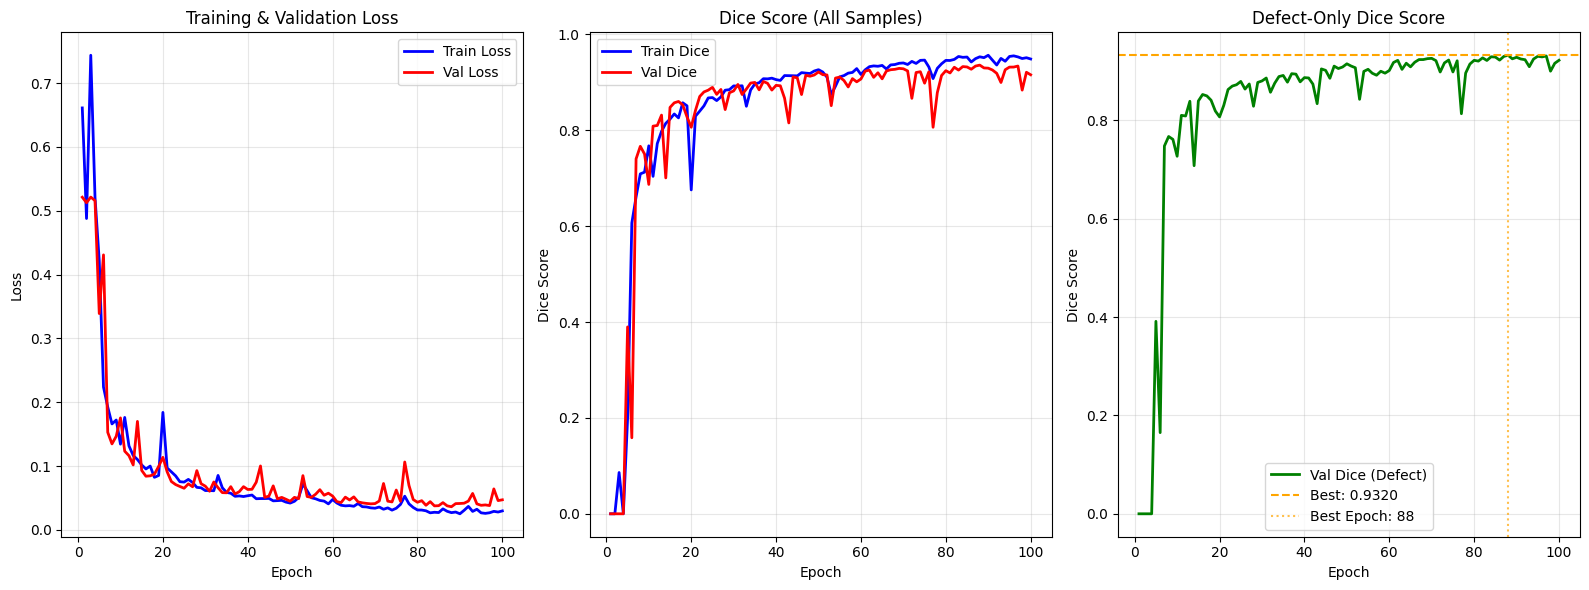

TRAINING SUMMARY
Final Train Loss: 0.0298
Final Val Loss: 0.0472
Final Val Dice (All): 0.9158
Final Val Dice (Defect): 0.9218
Best Val Dice (Defect): 0.9320
Best Epoch: 88


In [20]:
plot_training_history(
    train_losses,
    val_losses,
    train_dices,
    val_dices,
    val_defect_dices
)

In [27]:
def inference_test_set(model, test_loader, criterion, device, threshold=0.5):
    """Inference model on test set"""
    test_result = validate(
        model=model,
        loader=test_loader,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    print("TEST RESULTS")
    print("=" * 40)
    print(f"Test Loss: {test_result.loss:.4f}")
    print(f"Test Dice (All): {test_result.metrics_all.dice:.4f}")
    print(f"Test IoU (All): {test_result.metrics_all.iou:.4f}")
    print(f"Test Precision (All): {test_result.metrics_all.precision:.4f}")
    print(f"Test Recall (All): {test_result.metrics_all.recall:.4f}")
    print()
    print("DEFECT-ONLY METRICS")
    print("-" * 30)
    print(f"Test Dice (Defects): {test_result.metrics_defect_only.dice:.4f}")
    print(f"Test IoU (Defects): {test_result.metrics_defect_only.iou:.4f}")
    print(f"Test Precision (Defects): {test_result.metrics_defect_only.precision:.4f}")
    print(f"Test Recall (Defects): {test_result.metrics_defect_only.recall:.4f}")
    return test_result


import matplotlib.pyplot as plt
import numpy as np
import torch

def inference_visualize(model, test_loader, device, threshold=0.5, num_samples=3):
    """모델 추론 결과를 [이미지, 마스크, 오버레이] 형태로 시각화"""
    model.eval()

    samples = []
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if len(samples) >= num_samples:
                break

            images, masks = batch[0], batch[1]
            images = images.to(device)

            # 모델 예측
            outputs = model(images)
            probs = torch.sigmoid(outputs)

            for j in range(images.size(0)):
                if len(samples) >= num_samples:
                    break

                # 이미지 역정규화 (필요 시 mean, std 값에 맞춰 수정)
                # 예: img = (images[j].cpu().permute(1, 2, 0).numpy() * std) + mean
                img = images[j].cpu().permute(1, 2, 0).numpy()

                # 정규화된 이미지인 경우 0~1 사이로 클리핑
                img = np.clip(img, 0, 1)

                # 예측 마스크 (Threshold 적용)
                prob_map = probs[j].cpu().squeeze().numpy()
                pred_mask = (prob_map > threshold).astype(np.float32)

                samples.append({
                    'image': img,
                    'pred_mask': pred_mask
                })

    # 사진 스타일대로 시각화 (행: 샘플 수, 열: 3개)
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    # 샘플이 1개일 때를 대비해 2차원 배열로 고정
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, sample in enumerate(samples):
        img = sample['image']
        mask = sample['pred_mask']

        # 1열: 원본 이미지 (이미지 위에 제목 표시)
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Image', fontsize=12)
        axes[i, 0].axis('off')

        # 2열: Mask (이진 예측 결과)
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Mask', fontsize=12)
        axes[i, 1].axis('off')

        # 3열: Overlay (이미지 + 마스크)
        axes[i, 2].imshow(img)
        # 예측된 마스크 영역만 색상을 입혀서 겹침 (빨간색 예시)
        overlay_mask = np.zeros((*mask.shape, 4)) # RGBA
        overlay_mask[..., 0] = 1.0  # Red 채널
        overlay_mask[..., 3] = mask * 0.5 # 마스크 영역의 투명도를 0.5로 설정

        axes[i, 2].imshow(overlay_mask)
        axes[i, 2].set_title('Overlay', fontsize=12)
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    return samples

TEST RESULTS
Test Loss: 0.0349
Test Dice (All): 0.9394
Test IoU (All): 0.8868
Test Precision (All): 0.9443
Test Recall (All): 0.9358

DEFECT-ONLY METRICS
------------------------------
Test Dice (Defects): 0.9353
Test IoU (Defects): 0.8820
Test Precision (Defects): 0.9303
Test Recall (Defects): 0.9449


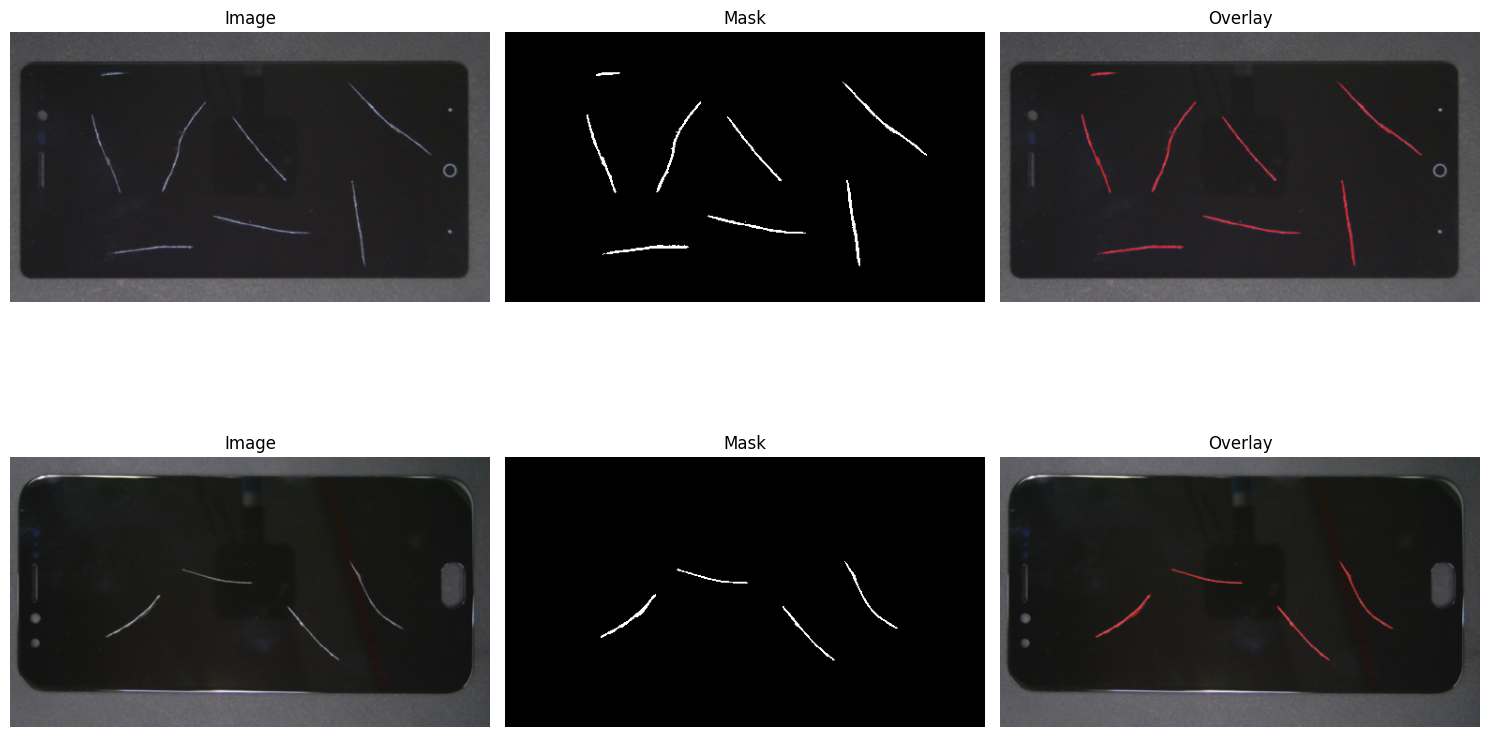

In [31]:
test_result = inference_test_set(unet, test_loader, criterion, device, threshold=0.5)
samples = inference_visualize(unet, test_loader, device, threshold=0.5, num_samples=2)

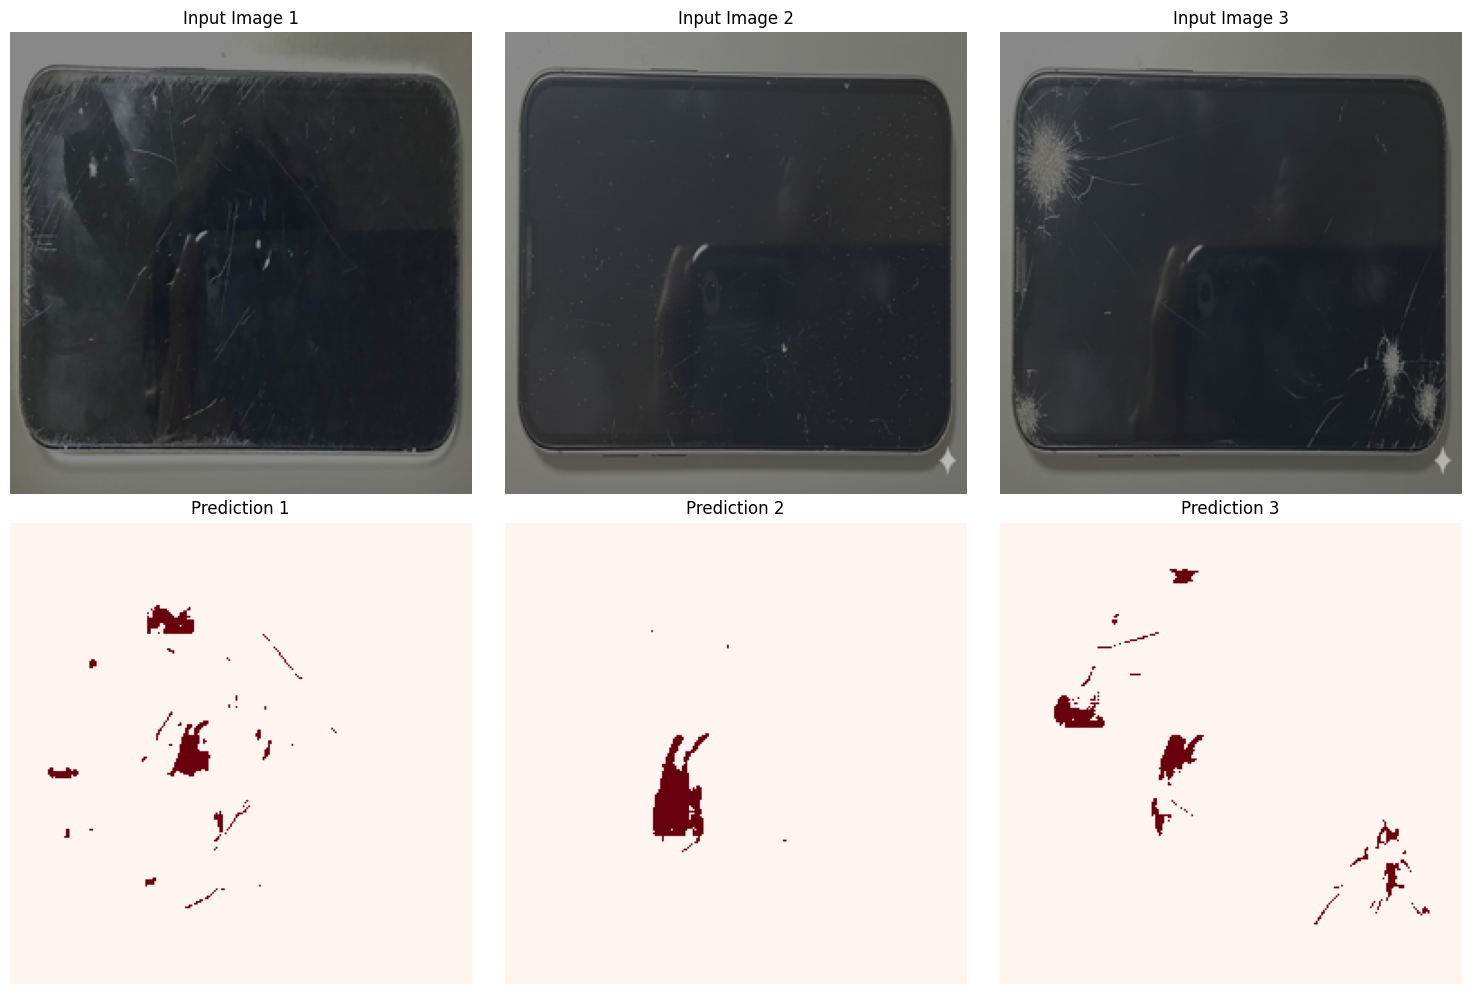

In [30]:
from PIL import Image
import glob

sample_test = f"{PROJECT_PATH}/data/Mobile Phone Defect/real"
img_files = glob.glob(f"{sample_test}/*.jpeg") + glob.glob(f"{sample_test}/*.png") + glob.glob(f"{sample_test}/*.jpg")

# 모든 이미지에 대해 처리
num_images = len(img_files)
fig, axes = plt.subplots(2, num_images, figsize=(5*num_images, 10))

# 이미지가 1개인 경우 axes 차원 조정
if num_images == 1:
    axes = axes.reshape(-1, 1)

for i, img_path in enumerate(img_files):
    # 이미지 로드
    img = Image.open(img_path).convert('RGB').resize((256, 256))
    img_array = np.array(img)

    # 예측
    img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.sigmoid(unet(img_tensor)).cpu().numpy()[0, 0]
        pred_binary = (pred > 0.5).astype(np.uint8)

    # 시각화
    axes[0, i].imshow(img_array)
    axes[0, i].set_title(f'Input Image {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(pred_binary, cmap='Reds')
    axes[1, i].set_title(f'Prediction {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

---

### Augmentation 600

- 이번엔 Class 별 Aug 200장씩 (good 클래스는 제외)
- 총 600장 증강

In [ ]:
# CLI 실행

# !python script/train.py --model "unet" --img_h 288 --img_w 512 --batch_size 16 --lr 1e-3 --base_channels 64 --epoch 100 --out_dir "/content/drive/MyDrive/likelion/smartphone_defect_segmentation/output/augmentation/" \
#   --augs bcg,blur,noise,specular,colorjitter \
#   --aug_p_img 0.2 --aug_p 0.3 \
#   --noise_std 0.03 \
#   --blur_sigma 1.2 \
#   --specular_strength 0.8 \
#   --specular_radius_min 20 \
#   --specular_radius_max 120 \
#   --cj_saturation 0.2 \
#   --cj_hue 0.03 \
#   --use_wandb